In [64]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.ML.Scoring.Scoring import CalcBEDROC
from sklearn.metrics import classification_report, make_scorer, f1_score, confusion_matrix, auc, roc_curve
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.functional import F
import torchbnn as bnn
from tqdm import tqdm
import json

# Prepare Dataset

In [65]:
data = pd.read_csv('./potency/SARS-CoV-2-Mpro_potencies_CONFIDENTIAL.csv')
data.head()

,SARS-CoV-2-MPro_fluorescence-dose-response_weizmann: IC50 (µM),SARS-CoV-2-MPro_fluorescence-dose-response_weizmann: IC50 CI (Lower) (µM),SARS-CoV-2-MPro_fluorescence-dose-response_weizmann: IC50 CI (Upper) (µM),SARS-CoV-2-MPro_fluorescence-dose-response_weizmann: Hill slope,SARS-CoV-2-MPro_fluorescence-dose-response_weizmann: pIC50 (log10M),Molecule Name,CXSMILES (CDD Compatible),Batch Created Date
0,13.440,12.303,14.682,1.045,4.87,ASAP-0029418,O=C(CC1=CN=CC2=CC=CC=C12)N1CCC(C2=CC=NO2)CC1,2024-07-08
1,7.993,7.024,9.096,1.030,5.10,ASAP-0029417,O=C(CC1=CN=CC2=CC=CC=C12)N1CCC[C@H](C2=CC=CC(F...,2024-07-08
2,48.046,43.210,53.424,1.114,4.32,ASAP-0029414,O=C(CC1=CN=CC2=CC=CC=C12)N1CCCC[C@H]1CC(F)(F)F...,2024-07-08
3,31.129,28.406,34.113,1.106,4.51,ASAP-0029413,O=C(CC1=CN=CC2=CC=CC=C12)N1CCC[C@H]1C1=NOC(C2C...,2024-07-08
4,27.025,24.688,29.582,1.103,4.57,ASAP-0029411,CCO[C@H]1C[C@H](C)N(C(=O)CC2=CN=CC3=CC=CC=C23)...,2024-07-08


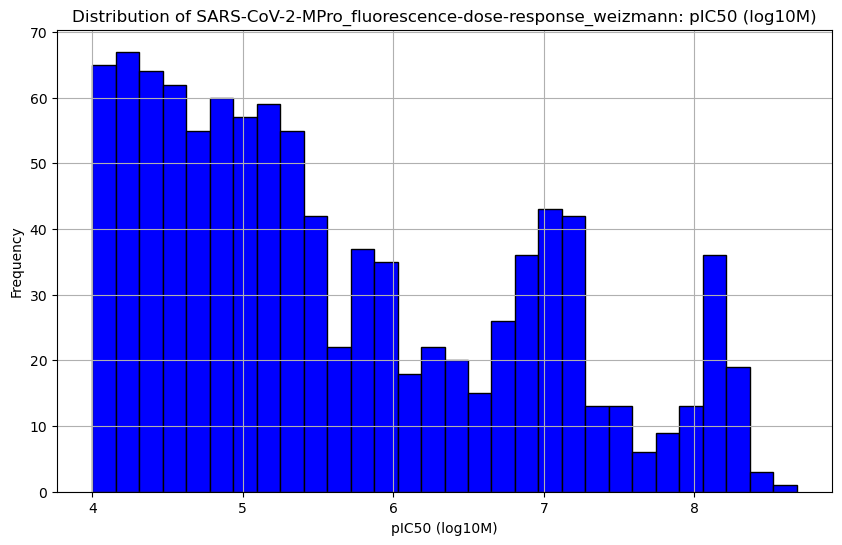

In [66]:
# Convert to numeric and drop NaN in one step
pIC50_data = pd.to_numeric(
    data['SARS-CoV-2-MPro_fluorescence-dose-response_weizmann: pIC50 (log10M)'],
    errors='coerce'
).dropna()

# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(pIC50_data, bins=30, color='blue', edgecolor='black')
plt.title('Distribution of SARS-CoV-2-MPro_fluorescence-dose-response_weizmann: pIC50 (log10M)')
plt.xlabel('pIC50 (log10M)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [67]:
data.rename(columns={'SARS-CoV-2-MPro_fluorescence-dose-response_weizmann: pIC50 (log10M)': 'pIC50'}, inplace=True)
data = data[['pIC50', 'Molecule Name', 'CXSMILES (CDD Compatible)']]
data.head()


,pIC50,Molecule Name,CXSMILES (CDD Compatible)
0,4.87,ASAP-0029418,O=C(CC1=CN=CC2=CC=CC=C12)N1CCC(C2=CC=NO2)CC1
1,5.10,ASAP-0029417,O=C(CC1=CN=CC2=CC=CC=C12)N1CCC[C@H](C2=CC=CC(F...
2,4.32,ASAP-0029414,O=C(CC1=CN=CC2=CC=CC=C12)N1CCCC[C@H]1CC(F)(F)F...
3,4.51,ASAP-0029413,O=C(CC1=CN=CC2=CC=CC=C12)N1CCC[C@H]1C1=NOC(C2C...
4,4.57,ASAP-0029411,CCO[C@H]1C[C@H](C)N(C(=O)CC2=CN=CC3=CC=CC=C23)...


In [68]:
data['MorganFP'] = data['CXSMILES (CDD Compatible)'].apply(
    lambda smi: AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(smi), radius=2, nBits=2048)
)
data.head()

,pIC50,Molecule Name,CXSMILES (CDD Compatible),MorganFP
0,4.87,ASAP-0029418,O=C(CC1=CN=CC2=CC=CC=C12)N1CCC(C2=CC=NO2)CC1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,5.10,ASAP-0029417,O=C(CC1=CN=CC2=CC=CC=C12)N1CCC[C@H](C2=CC=CC(F...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,4.32,ASAP-0029414,O=C(CC1=CN=CC2=CC=CC=C12)N1CCCC[C@H]1CC(F)(F)F...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,4.51,ASAP-0029413,O=C(CC1=CN=CC2=CC=CC=C12)N1CCC[C@H]1C1=NOC(C2C...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,4.57,ASAP-0029411,CCO[C@H]1C[C@H](C)N(C(=O)CC2=CN=CC3=CC=CC=C23)...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [69]:
data.dropna(subset=['CXSMILES (CDD Compatible)', 'pIC50'], inplace=True)
print(data.shape)
data.head()

(1326, 4)


,pIC50,Molecule Name,CXSMILES (CDD Compatible),MorganFP
0,4.87,ASAP-0029418,O=C(CC1=CN=CC2=CC=CC=C12)N1CCC(C2=CC=NO2)CC1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,5.10,ASAP-0029417,O=C(CC1=CN=CC2=CC=CC=C12)N1CCC[C@H](C2=CC=CC(F...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,4.32,ASAP-0029414,O=C(CC1=CN=CC2=CC=CC=C12)N1CCCC[C@H]1CC(F)(F)F...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,4.51,ASAP-0029413,O=C(CC1=CN=CC2=CC=CC=C12)N1CCC[C@H]1C1=NOC(C2C...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,4.57,ASAP-0029411,CCO[C@H]1C[C@H](C)N(C(=O)CC2=CN=CC3=CC=CC=C23)...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [70]:
def convert_pIC50(value):
    if isinstance(value, str):
        if value.startswith('<'):
            return float(value[1:])
        elif value.startswith('>'):
            return None  # Drop the value
        else:
            return float(value)
    return float(value)

# Apply the conversion function to the pIC50 column
data['pIC50'] = data['pIC50'].apply(convert_pIC50)

# Drop rows with None values in pIC50 column
data.dropna(subset=['pIC50'], inplace=True)

# Convert pIC50 column to integer type
data['pIC50'] = data['pIC50'].astype(float)

data.head()

,pIC50,Molecule Name,CXSMILES (CDD Compatible),MorganFP
0,4.87,ASAP-0029418,O=C(CC1=CN=CC2=CC=CC=C12)N1CCC(C2=CC=NO2)CC1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,5.10,ASAP-0029417,O=C(CC1=CN=CC2=CC=CC=C12)N1CCC[C@H](C2=CC=CC(F...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,4.32,ASAP-0029414,O=C(CC1=CN=CC2=CC=CC=C12)N1CCCC[C@H]1CC(F)(F)F...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,4.51,ASAP-0029413,O=C(CC1=CN=CC2=CC=CC=C12)N1CCC[C@H]1C1=NOC(C2C...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,4.57,ASAP-0029411,CCO[C@H]1C[C@H](C)N(C(=O)CC2=CN=CC3=CC=CC=C23)...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [71]:
# Extract features (X) and labels (y)
X = np.array(list(data["MorganFP"]))
y= data["pIC50"].values

# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("X_train_new:", X_train.shape, "X_test:", X_test.shape)
print("y_train_new:", y_train.shape, "y_test:", y_test.shape)

X_train_new: (1028, 2048) X_test: (258, 2048)
y_train_new: (1028,) y_test: (258,)


# Load Model

In [72]:
class EnhancedBayesianNNModel(nn.Module):
    def __init__(self, input_features, hidden_units1, hidden_units2, kl_weight, prior_mu, prior_sigma):
        super(EnhancedBayesianNNModel, self).__init__()
        self.fc1 = bnn.BayesLinear(prior_mu=prior_mu, prior_sigma=prior_sigma, in_features=input_features, out_features=hidden_units1)
        self.fc2 = bnn.BayesLinear(prior_mu=prior_mu, prior_sigma=prior_sigma, in_features=hidden_units1, out_features=hidden_units2)
        self.fc3 = bnn.BayesLinear(prior_mu=prior_mu, prior_sigma=prior_sigma, in_features=hidden_units2, out_features=1)
        self.kl_weight = kl_weight

    def forward(self, x):
        x = F.leaky_relu(self.fc1(x))
        x = F.leaky_relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [73]:
with open('SARS_potencie_BNN_model_hyperparameters.json') as f:
    model_hyperparameters = json.load(f)


print(model_hyperparameters)
# Load the pretrained model with the specified hyperparameters
model = EnhancedBayesianNNModel(
    input_features=2048,
    hidden_units1=model_hyperparameters['hidden_dim1'],
    hidden_units2=model_hyperparameters['hidden_dim2'],
    kl_weight=model_hyperparameters['kl_weight'],
    prior_mu=0,
    prior_sigma=0.1
)

# Load the model weights
model.load_state_dict(torch.load('SARS_potencie_BNN_model.pth'))

# Set the model to evaluation mode
model.eval()

{'hidden_dim1': 50, 'hidden_dim2': 25, 'kl_weight': 0.001, 'lr': 0.01}


EnhancedBayesianNNModel(
  (fc1): BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=2048, out_features=50, bias=True)
  (fc2): BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=50, out_features=25, bias=True)
  (fc3): BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=25, out_features=1, bias=True)
)

# Evaluate

In [74]:
def comprehensive_evaluation(model, X_test, y_test, n_samples=25):
    # Convert test data to tensor
    X_test_tensor = torch.FloatTensor(X_test)
    # Initialize lists to store predictions
    all_predictions = []
    
    # Generate multiple predictions using the Bayesian model
    model.eval()
    with torch.no_grad():
        for _ in range(n_samples):
            predictions = model(X_test_tensor).numpy().flatten()
            all_predictions.append(predictions)
    
    # Convert predictions to numpy array
    all_predictions = np.array(all_predictions)  # Shape: (n_samples, n_test_points)
    
    # Calculate mean and std of predictions
    mean_predictions = np.mean(all_predictions, axis=0)
    std_predictions = np.std(all_predictions, axis=0)
    
    # Calculate metrics
    mse = np.mean((mean_predictions - y_test) ** 2)
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(mean_predictions - y_test))
    r2 = 1 - np.sum((y_test - mean_predictions) ** 2) / np.sum((y_test - np.mean(y_test)) ** 2)
    
    # Print metrics
    print(f"Mean Squared Error: {mse:.4f}")
    print(f"Root Mean Squared Error: {rmse:.4f}")
    print(f"Mean Absolute Error: {mae:.4f}")
    print(f"R² Score: {r2:.4f}")
    
    # Create visualizations
    plt.figure(figsize=(15, 5))
    
    # Scatter plot of predicted vs actual values
    plt.subplot(131)
    plt.scatter(y_test, mean_predictions, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Predicted vs Actual Values')
    
    # Residual plot
    plt.subplot(132)
    residuals = y_test - mean_predictions
    plt.scatter(mean_predictions, residuals, alpha=0.5)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.title('Residual Plot')
    
    # Error distribution with uncertainty
    plt.subplot(133)
    plt.hist(residuals, bins=30, alpha=0.5, color='blue')
    plt.xlabel('Prediction Error')
    plt.ylabel('Frequency')
    plt.title('Error Distribution')
    plt.tight_layout()
    plt.show()
    
    # Enhanced uncertainty visualization using all forward passes
    plt.figure(figsize=(12, 7))
    
    # Plot individual predictions from each forward pass
    for i in range(n_samples):
        plt.scatter(y_test, all_predictions[i], alpha=0.1, color='blue', s=10)
    
    # Plot mean predictions with error bars
    plt.errorbar(y_test, mean_predictions, yerr=std_predictions, 
                fmt='o', color='red', alpha=0.5, label='Mean ± Std',
                markersize=4, elinewidth=1, capsize=2)
    
    # Perfect prediction line
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
             'k--', lw=2, label='Perfect Prediction')
    
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Predictions with Uncertainty\n(25 Forward Passes)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    return {
        'mse': mse,
        'rmse': rmse,
        'mae': mae,
        'r2': r2,
        'mean_predictions': mean_predictions,
        'std_predictions': std_predictions,
        'all_predictions': all_predictions  # Added to return all individual predictions
    }

Mean Squared Error: 0.5996
Root Mean Squared Error: 0.7744
Mean Absolute Error: 0.5857
R² Score: 0.6446


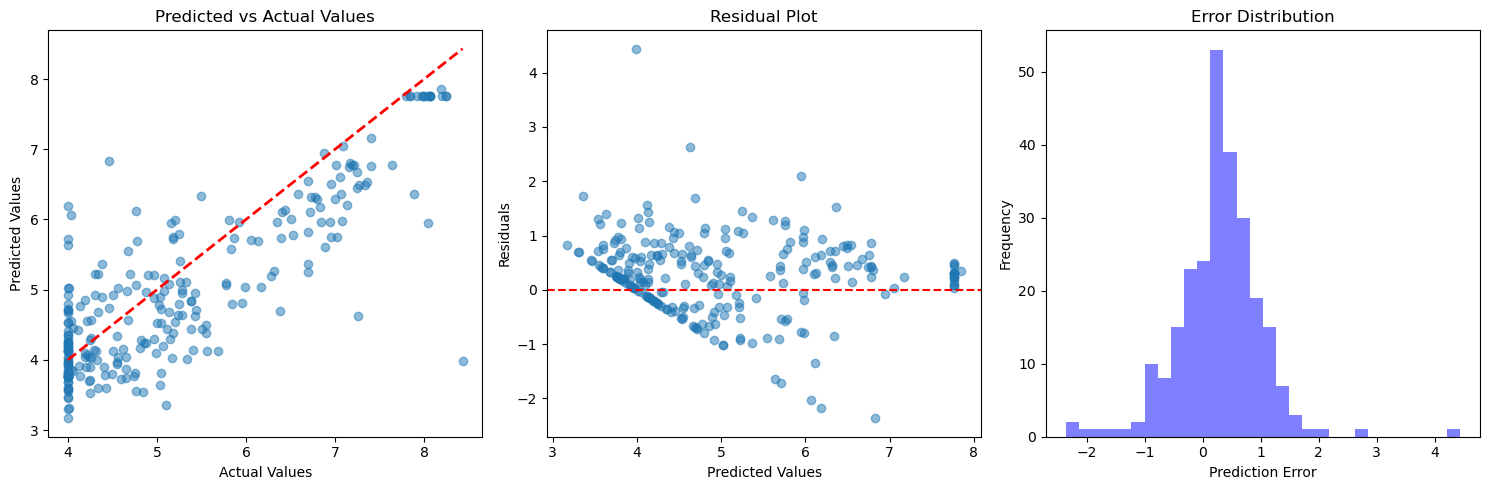

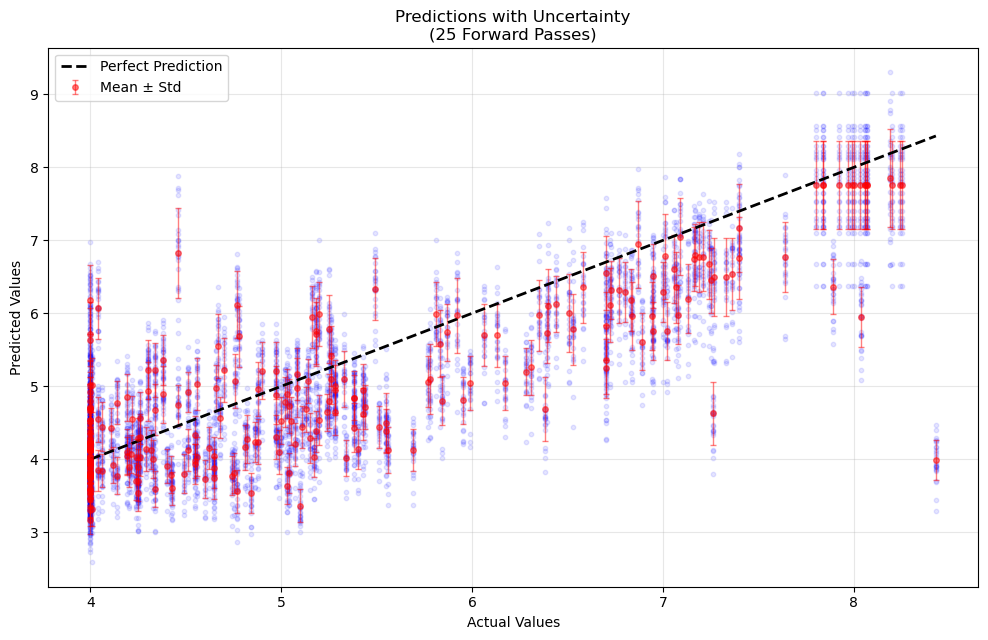

In [75]:
results = comprehensive_evaluation(model, X_test, y_test)

# Prediction

In [84]:
prd_data = pd.read_csv('./potency/test_potency.csv', index_col=0)
prd_data.head()

,SMILES
0,C=CC(=O)NC1=CC=CC(N(CC2=CC=CC(Cl)=C2)C(=O)CC2=...
1,CNC(=O)CN1C[C@@]2(C(=O)N(C3=CN=CC4=CC=CC=C34)C...
2,CNC(=O)CN1C[C@]2(CCN(C3=CN=CC4=CC=C(OC[C@H](O)...
3,CNC(=O)CN1C[C@@]2(C(=O)N(C3=CN=CC4=CC=CC=C34)C...
4,CNC(=O)CN1C[C@@]2(C(=O)N(C3=CN=CC4=CC=CC=C34)C...


In [85]:
prd_data['MorganFP'] = prd_data['SMILES'].apply(
    lambda smi: AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(smi), radius=2, nBits=2048)
)
prd_data.head()

,SMILES,MorganFP
0,C=CC(=O)NC1=CC=CC(N(CC2=CC=CC(Cl)=C2)C(=O)CC2=...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ..."
1,CNC(=O)CN1C[C@@]2(C(=O)N(C3=CN=CC4=CC=CC=C34)C...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,CNC(=O)CN1C[C@]2(CCN(C3=CN=CC4=CC=C(OC[C@H](O)...,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,CNC(=O)CN1C[C@@]2(C(=O)N(C3=CN=CC4=CC=CC=C34)C...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,CNC(=O)CN1C[C@@]2(C(=O)N(C3=CN=CC4=CC=CC=C34)C...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [89]:
import torch
import numpy as np
import pandas as pd

def predict_bayesian_with_uncertainty(model, df, feature_columns, prediction_column_base='predicted', n_samples=100):
    """
    Run multiple predictions with a Bayesian Neural Network and compute uncertainty metrics.
    Handles Morgan fingerprints stored in DataFrame columns.
    
    Parameters:
    model: EnhancedBayesianNNModel instance
    df: pandas DataFrame
    feature_columns: list of column names to use as features
    prediction_column_base: base name for prediction columns
    n_samples: number of prediction passes (default: 100)
    
    Returns:
    DataFrame with added prediction columns (mean, std)
    """
    # Ensure model is in evaluation mode
    model.eval()
    
    # Handle Morgan fingerprints
    if len(feature_columns) == 1 and feature_columns[0] == 'MorganFP':
        # Convert list of fingerprints to numpy array
        # Assuming each fingerprint is already a numpy array or can be converted to one
        fingerprints = np.stack(df['MorganFP'].values)
        input_data = torch.FloatTensor(fingerprints)
    else:
        # For other types of features
        try:
            input_data = torch.FloatTensor(df[feature_columns].values)
        except TypeError as e:
            print(f"Error converting features to tensor. Feature shapes: {[df[col].iloc[0].shape if hasattr(df[col].iloc[0], 'shape') else type(df[col].iloc[0]) for col in feature_columns]}")
            raise e
    
    # Storage for all predictions
    all_predictions = []
    
    # Run multiple predictions
    with torch.no_grad():
        for _ in range(n_samples):
            predictions = model(input_data).numpy().flatten()
            all_predictions.append(predictions)
    
    # Convert to numpy array
    all_predictions = np.array(all_predictions)  # Shape: (n_samples, n_test_points)
    
    # Calculate statistics
    mean_predictions = np.mean(all_predictions, axis=0)
    std_predictions = np.std(all_predictions, axis=0)
    
    # Add predictions to DataFrame
    df_with_predictions = df.copy()
    df_with_predictions[f'{prediction_column_base}_mean'] = mean_predictions
    df_with_predictions[f'{prediction_column_base}_std'] = std_predictions
    
    # Add confidence intervals (95%)
    confidence_interval = 1.96 * std_predictions  # 95% confidence interval
    df_with_predictions[f'{prediction_column_base}_lower'] = mean_predictions - confidence_interval
    df_with_predictions[f'{prediction_column_base}_upper'] = mean_predictions + confidence_interval
    
    # Store all predictions in a dictionary format
    predictions_dict = {
        'mean_predictions': mean_predictions,
        'std_predictions': std_predictions,
        'all_predictions': all_predictions,
        'confidence_interval_95': confidence_interval
    }
    
    return df_with_predictions, predictions_dict

# Helper function to check data structure
def inspect_fingerprint_data(df, feature_columns):
    """
    Inspect the structure of fingerprint data to help with debugging
    """
    for col in feature_columns:
        first_item = df[col].iloc[0]
        print(f"Column: {col}")
        print(f"Type of first item: {type(first_item)}")
        if hasattr(first_item, 'shape'):
            print(f"Shape of first item: {first_item.shape}")
        print(f"First few rows dtype: {df[col].dtype}")
        print("---")

In [90]:
inspect_fingerprint_data(prd_data, ['MorganFP'])

# Then run the predictions
df_with_predictions, predictions_info = predict_bayesian_with_uncertainty(
    model=model,
    df=prd_data,
    feature_columns=['MorganFP'],
    prediction_column_base='predicted',
    n_samples=100
)

Column: MorganFP
Type of first item: <class 'rdkit.DataStructs.cDataStructs.ExplicitBitVect'>
First few rows dtype: object
---


In [92]:
df_with_predictions.head()

,SMILES,MorganFP,predicted_mean,predicted_std,predicted_lower,predicted_upper
0,C=CC(=O)NC1=CC=CC(N(CC2=CC=CC(Cl)=C2)C(=O)CC2=...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...",4.593838,0.420391,3.769871,5.417805
1,CNC(=O)CN1C[C@@]2(C(=O)N(C3=CN=CC4=CC=CC=C34)C...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",5.460543,0.497900,4.484660,6.436427
2,CNC(=O)CN1C[C@]2(CCN(C3=CN=CC4=CC=C(OC[C@H](O)...,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",5.208256,0.475470,4.276335,6.140178
3,CNC(=O)CN1C[C@@]2(C(=O)N(C3=CN=CC4=CC=CC=C34)C...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",3.893404,0.367014,3.174058,4.612751
4,CNC(=O)CN1C[C@@]2(C(=O)N(C3=CN=CC4=CC=CC=C34)C...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",5.690883,0.519311,4.673034,6.708733
